# Quickstart

<div class="alert alert-block alert-success">
<b>Up to you:</b> To launch this notebook, you have to:<br/>
1. Go to tracklib/doc/source/notebook on a console,<br/>
2. Start the notebook server from the command line: jupyter notebook,<br/>
3. You should see the notebook open in your browser. Open "Switchbacks" by clicking on the link.<br/>
</div>


## Import de la librairie tracklib

In [1]:
import matplotlib.pyplot as plt
import os
import sys

#-------------------------------------------------------
# Import de tracklib

module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Read GPX data and plot track

?? ../../../data/gpx/activity_5807084803.gpx


<AxesSubplot: xlabel='E (m)', ylabel='N (m)'>

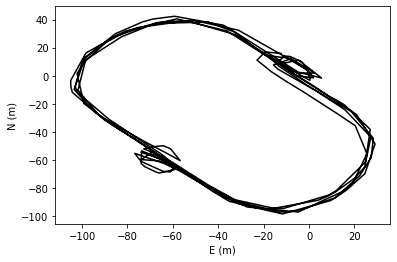

In [2]:
from tracklib.core.GPSTime import GPSTime
from tracklib.io.TrackReader import TrackReader

# ---------------------------------------------------
# Lecture des donnees
# ---------------------------------------------------
GPSTime.setReadFormat("4Y-2M-2DT2h:2m:2sZ")

tracks = TrackReader.readFromGpx('../../../data/gpx/activity_5807084803.gpx')
trace = tracks.getTrack(0)

# Transformation GEO coordinates to ENU
trace.toENUCoords()

# Display
trace.plot()

## Compute local speed

In [3]:
trace.estimate_speed()
print ('')
track = trace.copy()

## Display different plot of speed observations

<AxesSubplot:title={'center':'Track 0'}, xlabel='E (m)', ylabel='N (m)'>

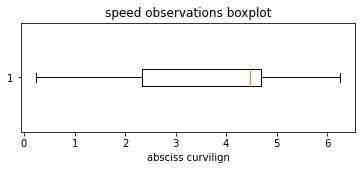

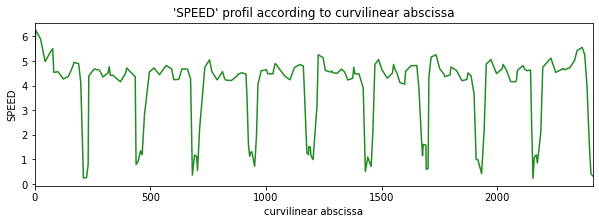

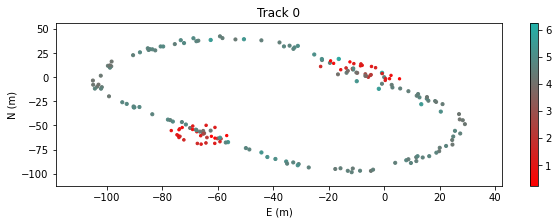

In [4]:
from tracklib.core.Plot import Plot

plot = Plot(trace)
plot.plotAnalyticalFeature('speed', 'BOXPLOT')  
plot.plotProfil('SPATIAL_SPEED_PROFIL')
plot.plot('POINT', 'speed')

## Summarize analytical features and plot it in image

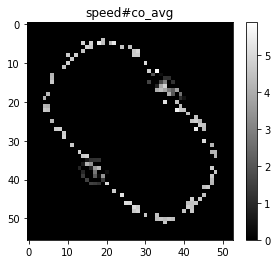

In [5]:
from tracklib.core.TrackCollection import TrackCollection
from tracklib.algo import (Summarising, Analytics) 

collection = TrackCollection([track])

af_algos = [Analytics.speed, Analytics.speed, Analytics.speed]
cell_operators = [Summarising.co_avg, Summarising.co_min, Summarising.co_max]
marge = 0.1
raster = Summarising.summarize(collection, af_algos, cell_operators, (3,3), marge)

raster.setColor((0, 0, 0), (255, 255, 255))
raster.plot(Analytics.speed, Summarising.co_avg, no_data_values = 0)

## Compute speed change

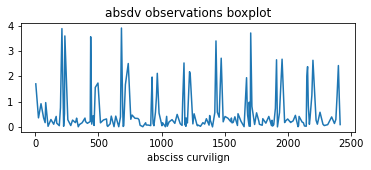

In [6]:
from tracklib.core.Operator import Operator

trace.operate(Operator.DIFFERENTIATOR, "speed", "dv")
trace.operate(Operator.RECTIFIER, "dv", "absdv")

# Speed change according to the curvilinear abscissa
plot = Plot(trace)
plot.plotAnalyticalFeature("absdv", "PLOT")

## Segmentation

Rep 1 :  vmoy =  16.85 km/h   vmax =  19.32  km/h   vc =  16.8 km/h
Rep 2 :  vmoy =  16.0 km/h   vmax =  17.04  km/h   vc =  16.15 km/h
Rep 3 :  vmoy =  16.34 km/h   vmax =  17.48  km/h   vc =  16.55 km/h
Rep 4 :  vmoy =  15.68 km/h   vmax =  16.56  km/h   vc =  15.9 km/h
Rep 5 :  vmoy =  16.26 km/h   vmax =  17.9  km/h   vc =  16.76 km/h
Rep 6 :  vmoy =  15.83 km/h   vmax =  17.11  km/h   vc =  16.32 km/h
Rep 7 :  vmoy =  15.99 km/h   vmax =  18.05  km/h   vc =  16.27 km/h
Rep 8 :  vmoy =  16.09 km/h   vmax =  18.84  km/h   vc =  16.42 km/h
Rep 9 :  vmoy =  16.32 km/h   vmax =  17.91  km/h   vc =  16.36 km/h
Rep 10 :  vmoy =  17.4 km/h   vmax =  20.2  km/h   vc =  18.17 km/h


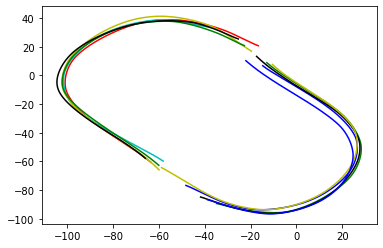

In [7]:
import tracklib.algo.Segmentation as segmentation
import tracklib.algo.Interpolation as interp

#  Segmentation
segmentation.segmentation(trace, ["absdv"], "speed_decoup", [1.5])

# ------------------------------------------------------------------
# + récupération d'un sous-ensemble de traces
# + interpolation/lissage + ré-estimation des vitesses...
# ------------------------------------------------------------------
seg = segmentation.split(trace, "speed_decoup")


# Affichage
COLORS = ['k-','r-','g-','b-','y-','m-','c-']

count = 0
interp.SPLINE_PENALIZATION = 1e-2
for i in range(len(seg)):
    trace = seg[i]
    if (trace.length() < 50):
        continue

    count += 1
    trace.resample(1, interp.ALGO_THIN_SPLINES, interp.MODE_SPATIAL)
    trace.estimate_speed()
    diff = trace.getLastObs().timestamp-trace.getFirstObs().timestamp
    v = round(trace.length()/diff*3.6,2)
    vm = round(trace.operate(Operator.MAX, "speed")*3.6,2)
    vc = round(100/(trace.getObs(150).timestamp-trace.getObs(50).timestamp)*3.6,2)
    print("Rep", count, ":  vmoy = ", v, "km/h   vmax = ", vm, " km/h   vc = ", vc, "km/h")
    plt.plot(trace.getX(), trace.getY(), COLORS[i%7])

plt.show()